# Log into Roboflow

In [ ]:
!pip install -q roboflow pyyaml

In [ ]:
import roboflow

# login to roboflow with email/password,
# then follow link to issue a new cli token in prompt
roboflow.login()

## Install dependecies


In [34]:
import torch

# remove quiet flag -q for debugging
!pip install -q onnx

if torch.cuda.is_available():
    !pip install -q onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
    PROVIDERS = ['CUDAExecutionProvider']
else:
    !pip install -q onnxruntime
    PROVIDERS = ['CPUExecutionProvider']

# TODO: fix crash when init model on cpu with both cpu and gpu providers in list
# e.g. PROVIDERS = ['CPUExecutionProvider', 'CUDAExecutionProvider']

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


In [35]:
# LATEST INSIGHTFACE IN PIP DOES NOT SUPPORT LATEST NUMPY
# SO FORCED DOWNDGRADE IS REQUIRED

# !pip install --no-deps insightface
# import numpy as np
# if np.__version__ != '1.22.3':
#     !pip install --force-reinstall numpy==1.22.3

# ALTERNATIVELY, INSTALL LATEST FROM GIT DIRECTLY (recommended)
# https://stackoverflow.com/a/77616935
!pip install -q 'insightface @ git+https://github.com/deepinsight/insightface/#subdirectory=python-package'

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


# Init model and create embeddings

## Model init

In [37]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

from PIL import Image, ImageOps
from matplotlib import pyplot as plt
import torch
import os

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [38]:
app = FaceAnalysis(name='buffalo_sc', providers = PROVIDERS)
app.prepare(ctx_id=0, det_size=(640, 640))

download_path: /root/.insightface/models/buffalo_sc


100%|██████████| 14619/14619 [00:00<00:00, 20563.87KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_sc/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_sc/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


## Prepare facebank embeddings

Roboflow датасет должен содержать изображения с подписанными классами. BBOX размечать необязательно, но чтобы этого не делать возможно придётся изменить формат датасета, либо найти функцию в Roboflow, чтобы подписывать картинки без разметки BBOX (я не нашёл).

Также есть баг когда подписанные изображения для какого-то класса в датасете присутствуют, но информация о них не содержится в data.yaml и labels/*.txt файлах (TODO).

### Load dataset in Yolo v7 format to facebank

In [46]:
#@title Yolov7 to facebank func
import pandas as pd
import yaml
import shutil
import os

def absoluteFilePaths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))

def yolo_to_facebank(yolo_dir, facebank_dir):
    yolo_train_dir = os.path.join(yolo_dir, 'train')
    images_dir = os.path.join(yolo_train_dir, 'images')
    labels_dir = os.path.join(yolo_train_dir, 'labels')

    data_file_path = os.path.join(yolo_dir, 'data.yaml')
    with open(data_file_path) as stream:
        try:
            data = yaml.safe_load(stream)
            class_names = data['names']
        except yaml.YAMLError as exc:
            print(exc)

    image_path_list = absoluteFilePaths(images_dir)
    label_path_list = absoluteFilePaths(labels_dir)
    max_class_label = -1
    empty_count = 0
    for image_path, label_path in zip(image_path_list, label_path_list):
        if os.stat(label_path).st_size != 0:
            label_df = pd.read_csv(label_path, header=None, sep=' ').squeeze(0)
            label = label_df[0].astype(int)
            facebank_person_path = os.path.join(facebank_dir, class_names[label])
            if label > max_class_label:
                max_class_label = label
                os.makedirs(facebank_person_path, exist_ok=True)

            image_filename = os.path.basename(image_path)
            image_facebank_path = os.path.join(facebank_person_path, image_filename)

            # delete existing images
            if os.path.exists(image_facebank_path):
                # skip in case the src and dst are the same file
                if os.path.samefile(image_path, image_facebank_path):
                    continue
                os.remove(image_facebank_path)

            shutil.copyfile(image_path, image_facebank_path)
        else:
            empty_count +=1

    print(f"Copied {max_class_label + 1} classes to facebank:", *class_names)
    print(f"Skipped {empty_count} images without labels.")

In [52]:
# Download dataset

from roboflow import Roboflow

rf = Roboflow()
project = rf.workspace("new-fr").project("ano_fr")
version = project.version(6)
dataset = version.download("yolov9")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ANO_FR-6 in yolov9:: 100%|██████████| 3060/3060 [00:06<00:00, 472.11it/s]


In [53]:
# Convert downloaded yolo dataset to facebank folder structure

YOLO_DIR = dataset.location
FACEBANK_DIR = './facebank'

yolo_to_facebank(YOLO_DIR, FACEBANK_DIR)

Copied 1 classes to facebank: Piotr_Birukov
Skipped 2 images without labels.


### Extract embeddings

In [54]:
#@title Embedding extraction func
def extract_face_embedding(filename, verbose=False):
    # TODO: hadle multiple faces (???)
    image = Image.open(filename)
    bands = image.getbands()
    if len(bands) == 4:
        image_rgb = Image.new("RGB", image.size, (255, 255, 255))
        image_rgb.paste(image, mask=image.split()[3]) # 3 is the alpha channel
        image = image_rgb

    img_arr = np.array(image)

    faces = app.get(img_arr)
    if len(faces) > 0:
        if len(faces) == 1:
            rimg = app.draw_on(img_arr, [faces[0]])
            if verbose:
                fig, ax = plt.subplots()
                ax.imshow(rimg)
                ax.axis('off')
        else:
            print(f'[SKIP] Multiple faces detected for image: {filename}')
            return None
    else:
        print(f'[SKIP] No embedding found for image: {filename}')
        return None

    return faces[0].embedding

def load_faces(dir, max_embs, verbose=False):
    face_embeddings = list()

    filenames = os.listdir(dir)
    embs_count = 0
    for filename in filenames:
        if embs_count == max_embs:
            break

        path = os.path.join(dir, filename)
        face_emb = extract_face_embedding(path, verbose)
        if face_emb is not None:
            face_embeddings.append(face_emb)
            embs_count += 1
    return face_embeddings

def load_dataset(dir, max_embs, required_size=(640, 640), verbose=False):
    # X, y = list(), list()
    X, y = list(), list(['N/A']) # reserve label at index 0 for inidentified images
    i = 1
    subdirs = [f for f in os.listdir(dir) if not f.startswith('.')]
    for subdir in subdirs:
        path = os.path.join(dir, subdir)
        faces = load_faces(path, max_embs, verbose)
        labels = [subdir for i in range(len(faces))]
        print("Loaded %d samples for class: %s" % (len(faces), subdir) )
        # face_emb_avg = np.stack(face_embeddings).mean(0)
        X.extend(faces)
        y.extend(labels)
        i+=1
    return np.array(X), np.array(y)

Loaded 3 samples for class: Piotr_Birukov


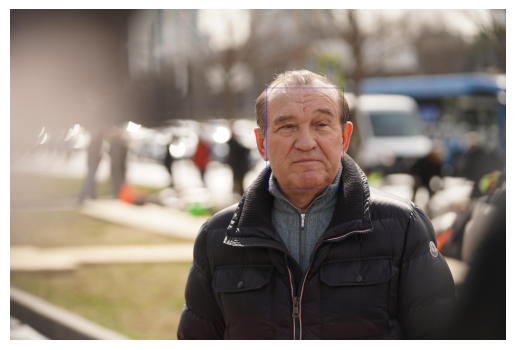

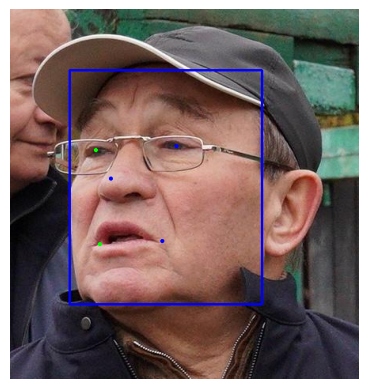

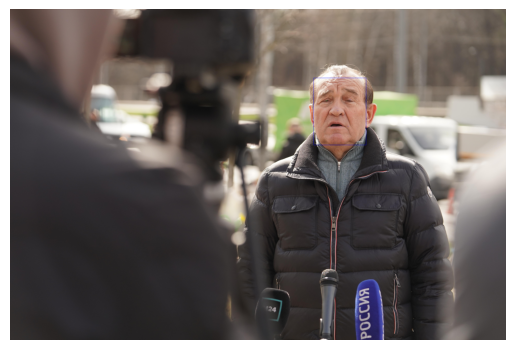

In [55]:
kwargs = dict(
    dir = FACEBANK_DIR,
    max_embs = 3, # max embeddings per person
    verbose = True # switch to false to not show images
)

# TODO: precompute embeddings
# TODO: store precomputed embeddings
FACEBANK_EMBS, FACEBANK_NAMES = load_dataset(**kwargs)

## Download videos

In [1]:
import os

VID_DIR = './videos'
if not os.path.isdir(VID_DIR):
    os.makedirs(VID_DIR)

# download a folder with videos from google drive
gdrive_link = '1pEnwdbDP8FuC6bBtaLNL4H_9uFRUkzDk'
!gdown --folder {gdrive_link} -O {VID_DIR}

Retrieving folder contents
Retrieving folder 1-6U6bdfcWajTglOSxywIIONpvczz_9XG .ipynb_checkpoints
Processing file 1aRq_uYuk7mvXVCeT6mp3bGRNF53_9-Jj 🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_Бирюков_Стартовали.mp4
Processing file 1--NHq73okNbTR-wSOyCAlZJkamt4sJN9 test.mp4
Processing file 1iDbwq2gzYITdD_cpTUCMBMiuHNQ0z1MZ Заместитель мэра Москвы по вопросам ЖКХ и благоустройства Петр Бирюков совершил рабочую поездку.mp4
Processing file 1hzp8woexBaeFvKWgIoqPrWgpeHuB-GUi Петр Бирюков дал интервью телеканалу Москва 24 - Москва 24.mp4
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1aRq_uYuk7mvXVCeT6mp3bGRNF53_9-Jj
From (redirected): https://drive.google.com/uc?id=1aRq_uYuk7mvXVCeT6mp3bGRNF53_9-Jj&confirm=t&uuid=cbec4a1e-f348-4221-8662-8a464e07c08d
To: /content/videos/🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_Бирюков_Стартовали.mp4
100% 129M/129M [00:03<00:00, 40.6M

In [ ]:
# Optionally use GDrive (recommended)
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Inference

## Functions

In [39]:
#@title Check codecs available in opencv
import cv2
from pprint import pprint

def is_fourcc_available(codec):
    try:
        fourcc = cv2.VideoWriter_fourcc(*codec)
        temp_video = cv2.VideoWriter('temp.mkv', fourcc, 30, (640, 480), isColor=True)
        return temp_video.isOpened()
    except:
        return False

def list_fourcc_codecs():
    codecs_to_test = ["DIVX", "XVID", "MJPG", "X264", "WMV1", "WMV2", "FMP4",
                      "mp4v", "avc1", "I420", "IYUV", "mpg1", "H264"]
    available_codecs = []
    for codec in codecs_to_test:
        available_codecs.append((codec, is_fourcc_available(codec)))

    print("Available FourCC codecs:")
    pprint(available_codecs)

In [42]:
list_fourcc_codecs()

Available FourCC codecs:
[('DIVX', True),
 ('XVID', True),
 ('MJPG', True),
 ('X264', False),
 ('WMV1', True),
 ('WMV2', True),
 ('FMP4', True),
 ('mp4v', True),
 ('avc1', False),
 ('I420', True),
 ('IYUV', True),
 ('mpg1', True),
 ('H264', False)]


In [43]:
#@title Classification using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

def classify(input_faces, target_embs, threshold=0.5):
    input_embs = [face.embedding for face in input_faces]
    input_embs = np.stack(input_embs)

    dist = cosine_similarity(input_embs, target_embs)
    idx_max = np.argmax(dist, axis=1, keepdims=True)
    maximum = np.take_along_axis(dist, idx_max, axis=1)
    idx_max[maximum < threshold] = -1

    # return idx_max.squeeze(), maximum.squeeze()
    return idx_max.squeeze(1) + 1, maximum.squeeze(1) # leave index 0 for 'Unknown' class

In [44]:
#@title Draw
def draw_outlined_text(img, text, pos, font_scale=0.6):
    # color_white = (255, 255, 255, 122)
    color_white = (255, 255, 255)
    color_black = (0, 0, 0)
    cv2.putText(img,
            '%s' % (text),
            pos,
            color=color_black,
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            thickness=5,
            fontScale=font_scale)
    cv2.putText(img,
            '%s' % (text),
            pos,
            color=color_white,
            fontFace=cv2.FONT_HERSHEY_COMPLEX,
            thickness=1,
            fontScale=font_scale)

def draw_on(img, faces, class_idx=None, scores=None):
        import cv2
        dimg = img.copy()
        for i in range(len(faces)):
            face = faces[i]
            box = face.bbox.astype(int)
            color = (0, 0, 255)
            cv2.rectangle(dimg, (box[0], box[1]), (box[2], box[3]), color, 2)
            # if face.kps is not None:
            #     kps = face.kps.astype(int)
            #     for l in range(kps.shape[0]):
            #         color = (0, 0, 255)
            #         if l == 0 or l == 3:
            #             color = (0, 255, 0)
            #         cv2.circle(dimg, (kps[l][0], kps[l][1]), 1, color,
            #                    2)
            # if face.gender is not None and face.age is not None:
            #     cv2.putText(dimg,'%s,%d'%(face.sex,face.age), (box[0]-1, box[1]-4),cv2.FONT_HERSHEY_COMPLEX,0.7,(0,255,0),1)

            if class_idx is not None:
                # coords = (box[0], box[1] - 10)
                coords = (box[0], box[3] + 40)
                draw_outlined_text(
                    dimg, FACEBANK_NAMES[class_idx[i]], coords
                )

                # coords = (box[0], box[1] - 30)
                coords = (box[0], box[3] + 20)
                if scores is not None and class_idx[i] != 0:
                    draw_outlined_text(
                        dimg, np.round(scores[i], 2), coords
                    )
        return dimg

## Inference on image

In [ ]:
FRAME_REL = 0.85 # Расположение кадра относительно начала видео
# TODO: указывать расположение в секундах
THRESHOLD = 0.5

vid_path = '/content/videos/🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_Бирюков_Стартовали.mp4'
cap = cv2.VideoCapture(vid_path)
total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.set(cv2.CAP_PROP_POS_FRAMES, int(total_frame_count * FRAME_REL))
ret, frame = cap.read()

faces = app.get(frame)
if len(faces) > 0:
    class_idx, scores = classify(faces, FACEBANK_EMBS, THRESHOLD)
else:
    print("No faces detected")

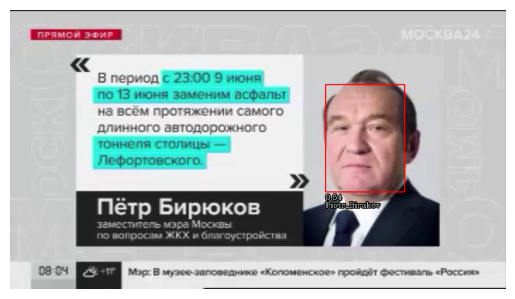

In [ ]:
rimg = draw_on(frame, faces, class_idx, scores)
cv2.imwrite("./demo.jpg", rimg)

rimg = cv2.cvtColor(rimg, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(rimg)
plt.show()

## Inference on video

In [48]:
#@title Inference func

from google.colab.patches import cv2_imshow
from google.colab import output
from tqdm.notebook import tqdm
import re
import time

def infer_video(input_path, output_path, skip_frames=None, max_frames=None):
    if max_frames is None:
        max_frames = float('inf')

    if skip_frames is None:
        skip_frames = 0

    cap = cv2.VideoCapture(input_path)
    total_frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    cap_width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width`
    cap_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height`
    cap_size = (int(cap_width), int(cap_height))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    # fourcc = cv2.VideoWriter_fourcc(*'X264')
    out = cv2.VideoWriter(output_path, fourcc, fps, cap_size)

    # out = cv2.VideoWriter(output_path, 0x21, fps, cap_size)

    if skip_frames > 0:
        cap.set(cv2.CAP_PROP_POS_FRAMES, skip_frames)

    frames_left = total_frame_count - skip_frames

    print(f'Processing video: {input_path}')
    pbar = tqdm(desc='Detecting: ', total=min(max_frames, frames_left))
    frame_count = 0
    frame_proc_time_list = []
    while cap.isOpened():
        frame_count += 1
        pbar.update(1)

        ret, frame = cap.read()

        if not ret:
            break

        start = time.perf_counter()
        faces = app.get(frame)

        if len(faces) > 0:
            class_idx, scores = classify(faces, FACEBANK_EMBS)
            rimg = draw_on(frame, faces, class_idx, scores)
        else:
            rimg = frame

        # rimg = draw_on(frame, faces)
        # plt.imshow(rimg)
        # plt.show()

        out.write(rimg)
        end = time.perf_counter()

        proc_time = end-start
        frame_proc_time_list.append(proc_time)
        pbar.set_postfix({"FPS": 1/proc_time})

        if frame_count == max_frames:
            break

    cap.release()
    out.release()
    # cv2.destroyAllWindows()

    frame_proc_time_list = np.array(frame_proc_time_list)
    total_proc_time = frame_proc_time_list.sum()
    FPS = 1 / frame_proc_time_list.mean()

    return FPS, total_proc_time

In [78]:
#@title Video detection func for folders
import pandas as pd
from pathlib import Path
import torch
from datetime import timedelta

def detect_videos(input_dir, output_dir=None, force_mode=None, force_list=None,
                 skip_frames=None, max_frames=None):
    """Detects and recognizes faces on all videos in 'input_dir', and writes
    corresponding detected videos to 'PARENT_FOLDER/output_dir' with _detected postfix.

    output_dir: str, defaults to input_dir_name + '_detected'

    If detected files already exist, you can re-run inference and overwrite them with 'force' option.
    Availible force modes:
        - 'prompt': prompt in console whether to overwrite existing output file. Prompts on every file.
        - 'all': overwrite all.
        - 'list': overwrite only files which indices are present in 'force_list'.
    """
    # TODO: skip_sec, max_sec instead of skip_frames, max_frames

    assert force_mode in [None, 'prompt', 'all', 'list']
    if force_mode == 'list':
        assert force_list is not None, \
            "If overwriting by list, a list of videos' indices must be provied in 'force_list'."

    if output_dir is None:
        input_dir_path = Path(input_dir)
        work_dir = input_dir_path.parent.absolute()
        output_dir = os.path.join(work_dir, input_dir_path.name + "_detected")

    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    perf_logs_path = os.path.join(output_dir, 'perf_logs.csv')
    if os.path.isfile(perf_logs_path):
        perf_logs_df = pd.read_csv(perf_logs_path)
    else:
        cols = ['output_file_name', 'total_proc_time', 'avg_proc_fps', 'device', 'date']
        perf_logs_df = pd.DataFrame(columns=cols)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    pattern = os.path.join(input_dir, '*.mp4')
    files = glob.glob(pattern)
    for input_file_idx, input_file_path in enumerate(files):
        output_file_name = Path(input_file_path).name.split('.')[0] + '_detected.mp4'
        output_file_path = os.path.join(output_dir, output_file_name)

        if os.path.isfile(output_file_path):
            print(f"Video is already detected at path: {input_file_path}")
            if force_mode == 'prompt':
                ans = input("\nOverwrite? [y/n]: ")
                if ans.lower() == 'y':
                    force = True
                else:
                    force = False
            elif force_mode == 'all':
                print("Forcing ovewriting due to force_mode=='all'.")
                force = True
            elif force_mode == 'list':
                force = input_file_idx in force_list
                if force:
                    print("Forcing ovewriting since file index is in 'force_list'.")
            elif force_mode == None:
                force = True
                print("Not overwriting due to force_mode='None'")
        else:
            print("Creating new detected video...")
            force = True

        if force:
            res = infer_video(input_file_path, output_file_path, skip_frames=skip_frames, max_frames=max_frames)
            if res is not None:
                total_proc_time, avg_proc_fps = res

                total_proc_time = pd.Timedelta(seconds=total_proc_time).round('s')
                print(f"[{device}] Total processing time: {total_proc_time}")
                print(f"[{device}] Average processing FPS: {avg_proc_fps:.2f}")
                print()

                perf_logs_dict = dict({
                    'output_file_name': output_file_name,
                    # 'total_proc_time': round(total_proc_time),
                    'total_proc_time': total_proc_time,
                    'avg_proc_fps': round(avg_proc_fps),
                    'device': device,
                    'date': pd.Timestamp("now").round('h')
                })
                perf_log = pd.DataFrame(perf_logs_dict, index=[0])
                idx = perf_logs_df['output_file_name'] == output_file_name
                if idx.sum() == 1:
                    perf_logs_df[idx] = perf_log.values
                else:
                    perf_logs_df = pd.concat([perf_logs_df, perf_log], ignore_index=True)
            else:
                print("Not overwriting.")

        perf_logs_df.to_csv(perf_logs_path, index=False)

    print(f"Performance logs available at: {perf_logs_path}")
    print(f"Output video folder: {output_dir}")
    return perf_logs_path, output_dir


In [79]:
INPUT_DIR = './videos' # insert your input_dir path
OUTPUT_DIR = './videos_detected' # output_dir generated by default

kwargs = dict(
    input_dir = INPUT_DIR,
    # output_dir = OUTPUT_DIR,
    force_mode = 'all', # check function docstring for all modes
    max_frames = 100,
    skip_frames = None,
)

perf_logs_path, detected_dir = detect_videos(**kwargs)

Video is already detected at path: ./videos/Заместитель мэра Москвы по вопросам ЖКХ и благоустройства Петр Бирюков совершил рабочую поездку.mp4
Forcing ovewriting due to force_mode=='all'.
Processing video: ./videos/Заместитель мэра Москвы по вопросам ЖКХ и благоустройства Петр Бирюков совершил рабочую поездку.mp4


Detecting:   0%|          | 0/100 [00:00<?, ?it/s]

[cpu] Total processing time: 0 days 00:00:10
[cpu] Average processing FPS: 9.62

Video is already detected at path: ./videos/🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_Бирюков_Стартовали.mp4
Forcing ovewriting due to force_mode=='all'.
Processing video: ./videos/🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_Бирюков_Стартовали.mp4


Detecting:   0%|          | 0/100 [00:00<?, ?it/s]

[cpu] Total processing time: 0 days 00:00:09
[cpu] Average processing FPS: 10.67

Video is already detected at path: ./videos/Петр Бирюков дал интервью телеканалу Москва 24 - Москва 24.mp4
Forcing ovewriting due to force_mode=='all'.
Processing video: ./videos/Петр Бирюков дал интервью телеканалу Москва 24 - Москва 24.mp4


Detecting:   0%|          | 0/100 [00:00<?, ?it/s]

[cpu] Total processing time: 0 days 00:00:10
[cpu] Average processing FPS: 9.92

Video is already detected at path: ./videos/test.mp4
Forcing ovewriting due to force_mode=='all'.
Processing video: ./videos/test.mp4


Detecting:   0%|          | 0/100 [00:00<?, ?it/s]

[cpu] Total processing time: 0 days 00:00:10
[cpu] Average processing FPS: 9.78

Performance logs available at: /content/videos_detected/perf_logs.csv
Output video folder: /content/videos_detected


In [80]:
# display performance logs
perf_logs_df = pd.read_csv(perf_logs_path)
perf_logs_df.head()

output_file_name  total_proc_time  \
0  Заместитель мэра Москвы по вопросам ЖКХ и благ...  0 days 00:00:10   
1  🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_...  0 days 00:00:09   
2  Петр Бирюков дал интервью телеканалу Москва 24...  0 days 00:00:10   
3                                  test_detected.mp4  0 days 00:00:10   

   avg_proc_fps device                 date  
0            10    cpu  2024-06-15 09:00:00  
1            11    cpu  2024-06-15 09:00:00  
2            10    cpu  2024-06-15 09:00:00  
3            10    cpu  2024-06-15 09:00:00

# Display videos

Чтобы отображать видео в колабе сначала их нужно сжать, перекодировав кодеком H.264 (libx264). Это очень медленный процесс и иногда не понятно, когда он закончитсяЮ потому что пока нет прогрессбара (TODO), поэтому КРАЙНЕ рекомендуется вместо этого проигрывать видео в браузере (если они сохранены на Google Drive) или локально.

Тем не менее если очень хочется отобразить пару видео, то это можно сделать, передав функции сжатия список id файлов подлежащих сжатию force_list вместе с аргументом force_mode='list'. Для этого сначала нужно вывести id всех файлов, выбрать нужные и сформировать список (пример ниже).

In [93]:
#@title Video compression func for folders
import pandas as pd
from pathlib import Path
import torch
import time
import glob

def compress_videos(input_dir, output_dir=None, force_mode=None, force_list=None,
                    skip_sec=None, max_sec=None):
    """Compresses all videos in 'input_dir' with h.264, and writes
    corresponding videos to 'PARENT_FOLDER/output_dir' with _compressed postfix,
    where PARENT_FOLDER is parent of 'input_dir'.

    output_dir: str, defaults to input_dir_name + '_compressed'

    If compressed files already exist, you can overwrite them with 'force' option.
    Availible force modes:
        - 'prompt': prompt in console whether to overwrite existing output file. Prompts on every file.
        - 'all': overwrite all.
        - 'list': overwrite only files which indices are present in 'force_list'.
    """

    assert force_mode in [None, 'prompt', 'all', 'list']
    if force_mode == 'list':
        assert force_list is not None, \
            "If overwriting by list, a list of videos' indices must be provied in 'force_list'."

    if output_dir is None:
        input_dir_path = Path(input_dir)
        work_dir = input_dir_path.parent.absolute()
        output_dir = os.path.join(work_dir, input_dir_path.name + "_compressed")

    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

    perf_logs_path = os.path.join(output_dir, 'perf_logs.csv')
    if os.path.isfile(perf_logs_path):
        perf_logs_df = pd.read_csv(perf_logs_path)
    else:
        cols = ['output_file_name', 'total_proc_time', 'device', 'date']
        perf_logs_df = pd.DataFrame(columns=cols)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    files = []
    for f in os.listdir(input_dir):
        full_file_path = os.path.join(input_dir, f)
        if os.path.isfile(full_file_path):
            files.append(full_file_path)

    pattern = os.path.join(input_dir, '*.mp4')
    files = glob.glob(pattern)
    for input_file_idx, input_file_path in enumerate(files):
        output_file_name = Path(input_file_path).name.split('.')[0] + '_compressed.mp4'
        output_file_path = os.path.join(output_dir, output_file_name)

        print()
        if os.path.isfile(output_file_path):
            print(f"Video is already compressed at path: {input_file_path}")
            if force_mode == 'prompt':
                ans = input("\nOverwrite? [y/n]: ")
                if ans.lower() == 'y':
                    force = True
                else:
                    force = False
            elif force_mode == 'all':
                print("Forcing ovewriting due to force_mode=='all'.")
                force = True
            elif force_mode == 'list':
                force = input_file_idx in force_list
                if force:
                    print("Forcing ovewriting since file index is in 'force_list'.")
                else:
                    print("Not overwriting since file index is NOT in 'force_list'")
            elif force_mode == None:
                force = True
                print("Not overwriting due to force_mode='None'")
        else:
            print("Creating new compressed video...")
            force = True

        if force:
            print(f'Compressing file {input_file_path}')
            timer_start = time.perf_counter()
            cmd = f"ffmpeg -y -i '{input_file_path}' -vcodec libx264"
            if skip_sec is not None:
                cmd += f' -ss {skip_sec}'
            if max_sec is not None:
                cmd += f' -t {max_sec}'
            cmd += f" '{output_file_path}'"
            res = os.system(cmd)
            timer_end = time.perf_counter()

            if res != 0:
                print("Compression error. To debug run following command in shell:")
                print(cmd)
            else:
                print(f'Done. Compressed video available at: {output_file_path}')
                if res is not None:
                    total_proc_time = timer_end - timer_start
                    total_proc_time = pd.Timedelta(seconds=total_proc_time).round('s')
                    print(f"[{device}] Total processing time: {total_proc_time}")
                    print()

                    perf_logs_dict = dict({
                        'output_file_name': output_file_name,
                        'total_proc_time': total_proc_time,
                        'device': device,
                        'date': pd.Timestamp("now").round('h')
                    })
                    perf_log = pd.DataFrame(perf_logs_dict, index=[0])
                    idx = perf_logs_df['output_file_name'] == output_file_name
                    if idx.sum() == 1:
                        perf_logs_df[idx] = perf_log.values
                    else:
                        perf_logs_df = pd.concat([perf_logs_df, perf_log], ignore_index=True)
                else:
                    print("Not overwriting.")

        perf_logs_df.to_csv(perf_logs_path, index=False)

    print(f"Performance logs available at: {perf_logs_path}")
    print(f"Output video folder: {output_dir}")
    return perf_logs_path, output_dir

In [94]:
import glob
from pprint import pprint

def print_files_ids(print_dir):
    pattern = os.path.join(path, '*.mp4')
    files = glob.glob(pattern)
    for file_path in enumerate(files):
        print(file_path)

path = detected_dir
print_files_ids(path)

(0, '/content/videos_detected/Заместитель мэра Москвы по вопросам ЖКХ и благоустройства Петр Бирюков совершил рабочую поездку_detected.mp4')
(1, '/content/videos_detected/test_detected.mp4')
(2, '/content/videos_detected/Петр Бирюков дал интервью телеканалу Москва 24 - Москва 24_detected.mp4')
(3, '/content/videos_detected/🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_Бирюков_Стартовали_detected.mp4')


In [95]:
INPUT_DIR = detected_dir # use detected_dir returned by detection function
INPUT_DIR = './videos_detected' # or paste your own
OUTPUT_DIR = detected_dir + '_compressed' # output_dir dir generated by default

kwargs = dict(
    input_dir = INPUT_DIR,
    # output_dir = OUTPUT_DIR,
    max_sec=10,
    force_mode = 'list',
    force_list = [1, 3] # применим сжатие только к файлам с номерами 1 и 3
)

perf_logs_dir = compress_videos(**kwargs)


Video is already compressed at path: ./videos_detected/Заместитель мэра Москвы по вопросам ЖКХ и благоустройства Петр Бирюков совершил рабочую поездку_detected.mp4
Not overwriting since file index is NOT in 'force_list'

Video is already compressed at path: ./videos_detected/test_detected.mp4
Forcing ovewriting since file index is in 'force_list'.
Compressing file ./videos_detected/test_detected.mp4
Done. Compressed video available at: /content/videos_detected_compressed/test_detected_compressed.mp4
[cpu] Total processing time: 0 days 00:00:08


Video is already compressed at path: ./videos_detected/Петр Бирюков дал интервью телеканалу Москва 24 - Москва 24_detected.mp4
Not overwriting since file index is NOT in 'force_list'

Video is already compressed at path: ./videos_detected/🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_Бирюков_Стартовали_detected.mp4
Forcing ovewriting since file index is in 'force_list'.
Compressing file ./videos_detected/🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_

In [77]:
perf_logs_df = pd.read_csv(perf_logs_path)
perf_logs_df.head()

output_file_name  total_proc_time  \
0  Заместитель мэра Москвы по вопросам ЖКХ и благ...  0 days 00:00:08   
1  🟢_ИНИЦИИРОВАНО_2023_06_10_08_01_Москва_24_П_П_...  0 days 00:00:06   
2  Петр Бирюков дал интервью телеканалу Москва 24...  0 days 00:00:09   
3                                  test_detected.mp4  0 days 00:00:09   

   avg_proc_fps device                 date  
0            12    cpu  2024-06-15 09:00:00  
1            18    cpu  2024-06-15 09:00:00  
2            11    cpu  2024-06-15 09:00:00  
3            11    cpu  2024-06-15 09:00:00

In [32]:
#@title Display video func
from IPython.display import HTML
from base64 import b64encode
import os

def show_video(input_path):
    # Show video
    mp4 = open(input_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    html = HTML("""
    <video width=640 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

    display(html)

In [33]:
# copy path from compression output in console
path = '/content/videos_compressed/test_compressed.mp4'
show_video(path)

# TODO: Add chapters to video

In [ ]:
from google.colab import drive
drive.mount('./drive')

Mounted at ./drive


In [ ]:
video_path = '/content/drive/MyDrive/practice/news-face-recognition/Петр_Бирюков/Заместитель мэра Москвы по вопросам ЖКХ и благоустройства Петр Бирюков совершил рабочую поездку.mp4'
video_path = "'" + video_path + "'"
metadata_path = 'metadata.txt'
!ffmpeg -y -i {video_path} -f ffmetadata {metadata_path} \
    -hide_banner -loglevel error
!cat {metadata_path}

;FFMETADATA1
encoder=Lavf58.76.100


In [ ]:
TIMEBASE = "1/1000"
START = 0
END = 30000
TITLE = "TITLE"

with open(metadata_path, 'a') as f:
    chapter_metadata = [
        "[CHAPTER]",
        f"TIMEBASE={TIMEBASE}",
        f"START={START}",
        f"END={END}",
        f"title={TITLE}"
    ]
    f.write("\n" +
            "\n".join(chapter_metadata)+
            '\n')

!cat {metadata_path}

;FFMETADATA1
encoder=Lavf58.76.100

[CHAPTER]
TIMEBASE=1/1000
START=0
END=30000
title=TITLE


In [ ]:
folder = '/content/drive/MyDrive/practice/news-face-recognition/Петр_Бирюков'
out_path = folder + '/test.mp4'
print(out_path)
!ffmpeg \
    -ss 0 -t 30 \
    -y -i {video_path} \
    -i {metadata_path} -map_metadata 1 -map_chapters 1 \
    -codec copy {out_path}
    # -to 00:02:00 \
    # -ss 00:01:00 \

/content/drive/MyDrive/practice/news-face-recognition/Петр_Бирюков/test.mp4
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --ena

In [ ]:
metadata_path = 'metadata2.txt'
!ffmpeg -y -i {out_path} -f ffmetadata {metadata_path}

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab